In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
import warnings
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import RegressorChain
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,ConfusionMatrixDisplay,classification_report
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.model_selection import train_test_split
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv', parse_dates=['date'])
submission = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv')
holidays = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv', parse_dates=['date'])
stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
train = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv', parse_dates=['date'])
test = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv', parse_dates=['date'])
transactions = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv', parse_dates=['date'])

1. EDA

In [3]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [4]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [5]:
oil['dcoilwtico'] =oil.dcoilwtico.interpolate()

In [6]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [7]:
holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [8]:
def insight(df):
    global categorical_columns, numerical_columns
    categorical_columns = df.select_dtypes(include=['object', 'bool']).columns
    numerical_columns = df.select_dtypes(exclude=['object', 'bool', 'datetime']).columns
    if len(numerical_columns) !=0:
        print('\n')
        print('-----------------')
        print('Numerical columns')
        print('-----------------')
        print('\n')
        for col in df[numerical_columns]:
            print(col)
            print('Min:', round(df[col].min(), 2))
            print('Max:', round(df[col].max(), 2))
            print('Mean:', round(df[col].mean(), 2))
          
        print('\n')
    print('-------------------')
    print('Categorical columns')
    print('-------------------')
    print('\n')
    for col in df[categorical_columns]:
        print(col)
        print("{} unique items: ".format(len(df[col].unique())), df[col].unique())
        print('\n')
       

In [9]:
insight(holidays)

-------------------
Categorical columns
-------------------


type
6 unique items:  ['Holiday' 'Transfer' 'Additional' 'Bridge' 'Work Day' 'Event']


locale
3 unique items:  ['Local' 'Regional' 'National']


locale_name
24 unique items:  ['Manta' 'Cotopaxi' 'Cuenca' 'Libertad' 'Riobamba' 'Puyo' 'Guaranda'
 'Imbabura' 'Latacunga' 'Machala' 'Santo Domingo' 'El Carmen' 'Cayambe'
 'Esmeraldas' 'Ecuador' 'Ambato' 'Ibarra' 'Quevedo'
 'Santo Domingo de los Tsachilas' 'Santa Elena' 'Quito' 'Loja' 'Salinas'
 'Guayaquil']


description
103 unique items:  ['Fundacion de Manta' 'Provincializacion de Cotopaxi'
 'Fundacion de Cuenca' 'Cantonizacion de Libertad'
 'Cantonizacion de Riobamba' 'Cantonizacion del Puyo'
 'Cantonizacion de Guaranda' 'Provincializacion de Imbabura'
 'Cantonizacion de Latacunga' 'Fundacion de Machala'
 'Fundacion de Santo Domingo' 'Cantonizacion de El Carmen'
 'Cantonizacion de Cayambe' 'Fundacion de Esmeraldas'
 'Primer Grito de Independencia' 'Fundacion de Riobamba'
 'Fund

In [10]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [11]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [12]:
stores['store_nbr'] = stores['store_nbr'].astype('object');
stores['cluster'] = stores['cluster'].astype('object');

In [13]:
insight(stores)

-------------------
Categorical columns
-------------------


store_nbr
54 unique items:  [1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51
 52 53 54]


city
22 unique items:  ['Quito' 'Santo Domingo' 'Cayambe' 'Latacunga' 'Riobamba' 'Ibarra'
 'Guaranda' 'Puyo' 'Ambato' 'Guayaquil' 'Salinas' 'Daule' 'Babahoyo'
 'Quevedo' 'Playas' 'Libertad' 'Cuenca' 'Loja' 'Machala' 'Esmeraldas'
 'Manta' 'El Carmen']


state
16 unique items:  ['Pichincha' 'Santo Domingo de los Tsachilas' 'Cotopaxi' 'Chimborazo'
 'Imbabura' 'Bolivar' 'Pastaza' 'Tungurahua' 'Guayas' 'Santa Elena'
 'Los Rios' 'Azuay' 'Loja' 'El Oro' 'Esmeraldas' 'Manabi']


type
5 unique items:  ['D' 'B' 'C' 'E' 'A']


cluster
17 unique items:  [13 8 9 4 6 15 7 3 12 16 1 10 2 5 11 14 17]




In [14]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [15]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


In [16]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [18]:
train.family.unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [19]:
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


2. Data Visualization

2.1 Oil 

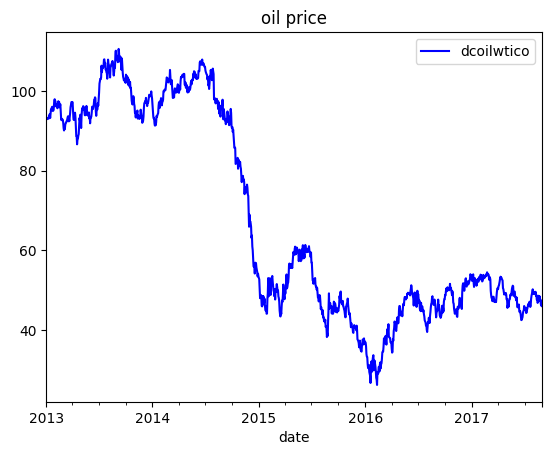

In [20]:
oil.plot.line(x="date", y="dcoilwtico", color='b', title ="oil price")
plt.show()

2.2 Holidays 

[Text(0, 0, '221'),
 Text(0, 0, '12'),
 Text(0, 0, '51'),
 Text(0, 0, '5'),
 Text(0, 0, '5'),
 Text(0, 0, '56')]

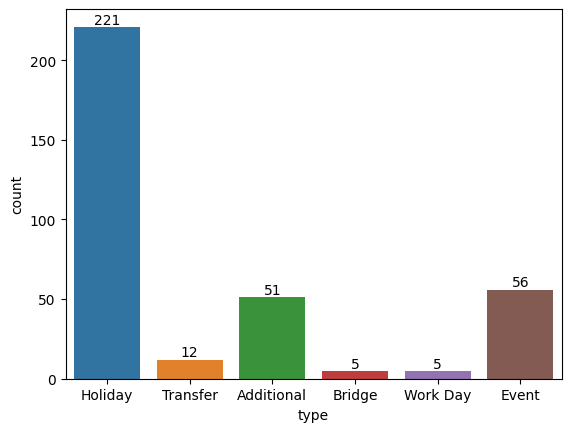

In [21]:
hol_types_plot = sns.countplot(data=holidays, x='type')
hol_types_plot.bar_label(hol_types_plot.containers[0])

[Text(0, 0, '152'), Text(0, 0, '24'), Text(0, 0, '174')]

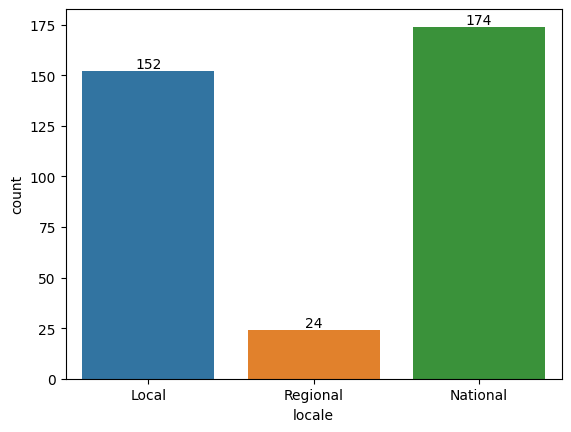

In [22]:
hol_locale_plot = sns.countplot(data=holidays, x='locale')
hol_locale_plot.bar_label(hol_locale_plot.containers[0])

[Text(0, 0, '338'), Text(0, 0, '12')]

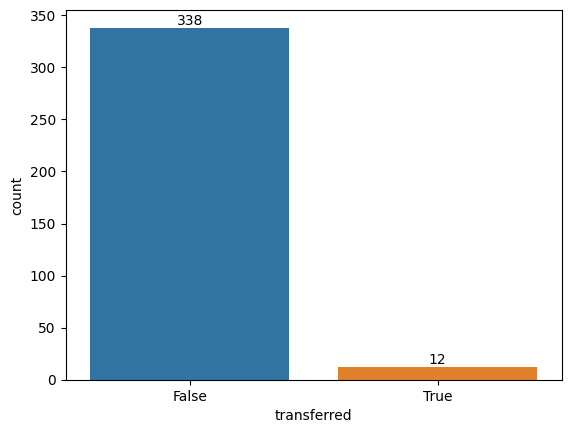

In [23]:
hol_transferred_plot = sns.countplot(data=holidays, x='transferred')
hol_transferred_plot.bar_label(hol_transferred_plot.containers[0])

2.3 Transactions

In [24]:
transactions['month'] = transactions['date'].dt.month
transactions['year'] = transactions['date'].dt.year
transactions['day_of_week'] = transactions['date'].dt.dayofweek+1
transactions['week'] = transactions['date'].dt.isocalendar().week

In [25]:
transactions

,date,store_nbr,transactions,month,year,day_of_week,week
0,2013-01-01,25,770,1,2013,2,1
1,2013-01-02,1,2111,1,2013,3,1
2,2013-01-02,2,2358,1,2013,3,1
3,2013-01-02,3,3487,1,2013,3,1
4,2013-01-02,4,1922,1,2013,3,1
...,...,...,...,...,...,...,...
83483,2017-08-15,50,2804,8,2017,2,33
83484,2017-08-15,51,1573,8,2017,2,33
83485,2017-08-15,52,2255,8,2017,2,33
83486,2017-08-15,53,932,8,2017,2,33


In [26]:
transactions_month = transactions.groupby(['year', 'month'])['transactions'].mean().reset_index()

In [27]:
transactions_week = transactions.groupby(['year', 'day_of_week'])['transactions'].mean().reset_index()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


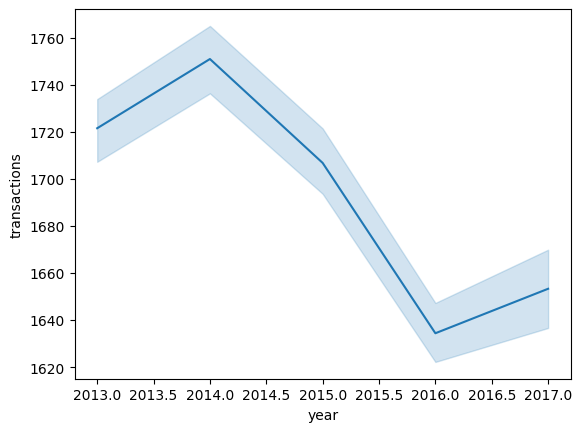

In [28]:
sns.lineplot(transactions, x='year', y='transactions');

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

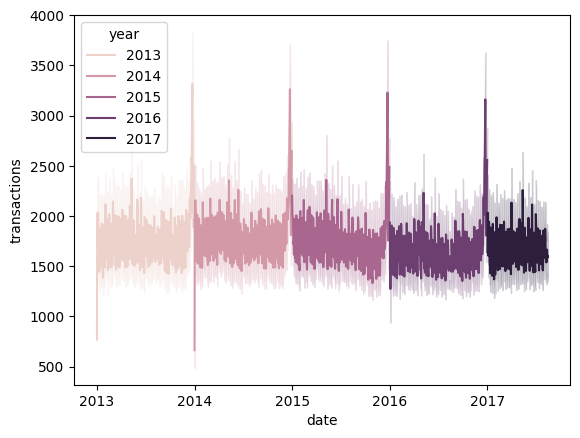

In [29]:
sns.lineplot(transactions, x='date', y='transactions', hue='year');

Seasonality

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

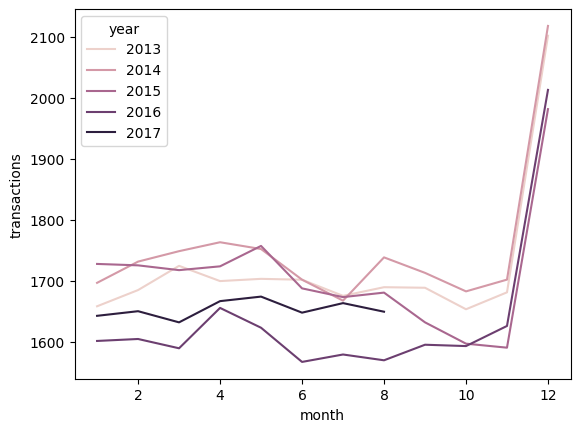

In [30]:
sns.lineplot(transactions_month, x='month', y='transactions', hue='year');

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

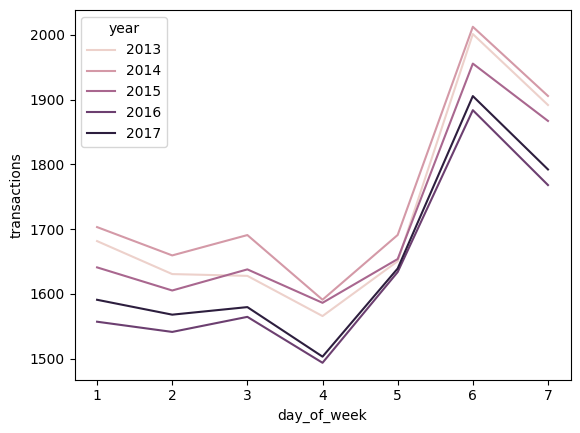

In [31]:
sns.lineplot(transactions_week, x='day_of_week', y='transactions', hue='year');

2.4 Sales

In [32]:
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day_of_week'] = train['date'].dt.dayofweek+1
train['week'] = train['date'].dt.isocalendar().week

In [33]:
sales = train.groupby('date')['sales'].mean().reset_index()
sales

,date,sales
0,2013-01-01,1.409438
1,2013-01-02,278.390807
2,2013-01-03,202.840197
3,2013-01-04,198.911154
4,2013-01-05,267.873244
...,...,...
1679,2017-08-11,463.733851
1680,2017-08-12,444.798280
1681,2017-08-13,485.768618
1682,2017-08-14,427.004717


In [34]:
sales['year'] = sales['date'].dt.year
sales['month'] = sales['date'].dt.month
sales['day_of_week'] = sales['date'].dt.dayofweek+1
sales['week'] = sales['date'].dt.isocalendar().week

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


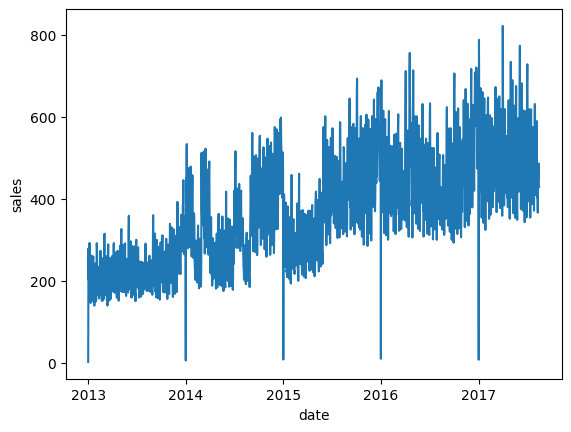

In [35]:
sns.lineplot(sales, x='date', y='sales');

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

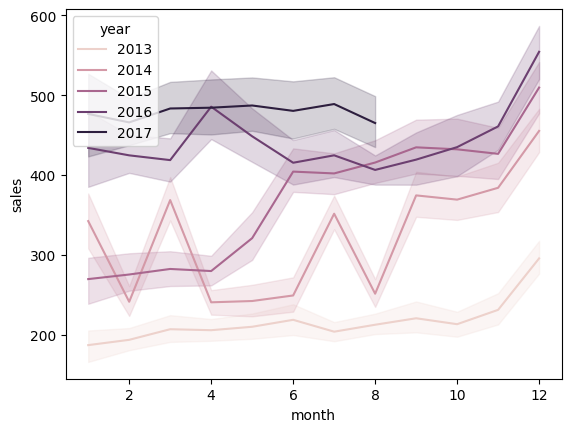

In [36]:
sns.lineplot(sales, x='month', y='sales', hue='year');

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

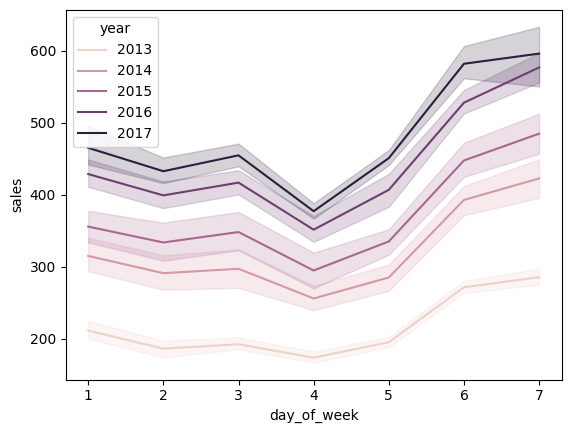

In [37]:
sns.lineplot(sales, x='day_of_week', y='sales', hue='year');

In [38]:
sales_beverage = train[train['family']=='BEVERAGES']
sales_beverage.groupby('date')['sales'].mean().reset_index()

,date,sales
0,2013-01-01,15.000000
1,2013-01-02,1335.037037
2,2013-01-03,964.907407
3,2013-01-04,1003.092593
4,2013-01-05,1441.074074
...,...,...
1679,2017-08-11,3502.055556
1680,2017-08-12,3376.259259
1681,2017-08-13,3747.296296
1682,2017-08-14,3237.629630


In [39]:
total_sales = train.groupby(['date','family'])['sales'].mean().reset_index().sort_values(by='sales',ascending=False)
top10_sales = train.groupby('family')['sales'].mean().reset_index().sort_values(by='sales',ascending=False).head(10)
last10_sales = train.groupby('family')['sales'].mean().reset_index().sort_values(by='sales',ascending=False).tail(10)

In [40]:
top_sales = total_sales[total_sales['family'].isin(top10_sales.family)]

In [41]:
top_sales.family.unique()

array(['GROCERY I', 'BEVERAGES', 'PRODUCE', 'CLEANING', 'MEATS', 'DAIRY',
       'BREAD/BAKERY', 'POULTRY', 'PERSONAL CARE', 'DELI'], dtype=object)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

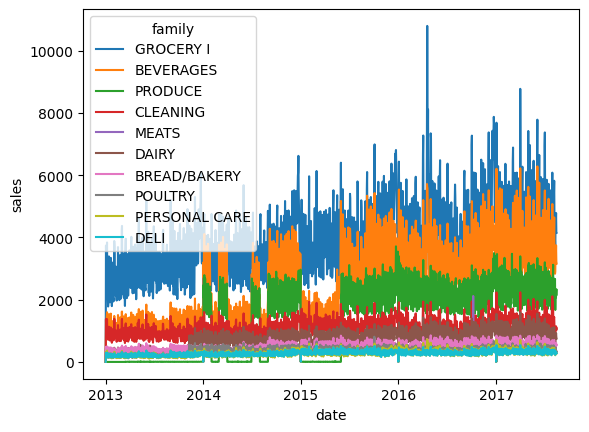

In [42]:
sns.lineplot(top_sales, x='date', y='sales', hue='family');

In [43]:
total_sales_2 = train.groupby('family')['sales'].mean().reset_index().sort_values(by='sales',ascending=False)

<Axes: xlabel='sales', ylabel='family'>

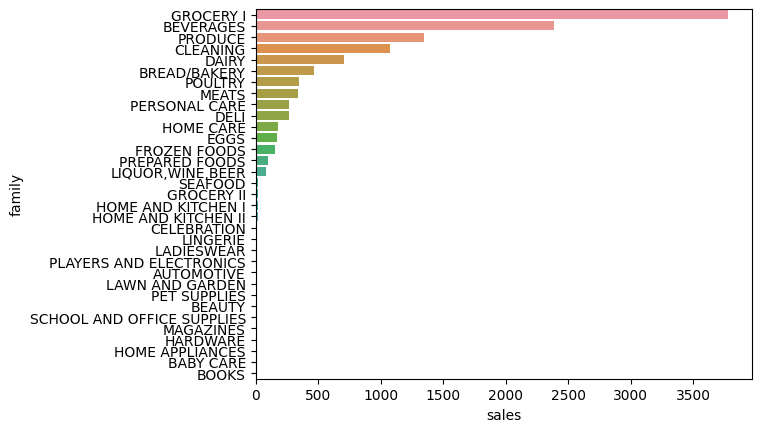

In [44]:
sns.barplot(total_sales_2, x='sales', y='family')

2.5 Moving Average

In [45]:
transactions_avg_week = transactions.set_index("date").resample("W").transactions.mean().reset_index()

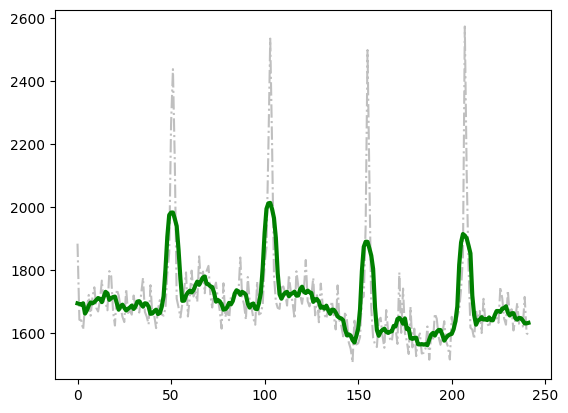

In [46]:
moving_average = transactions_avg_week['transactions'].rolling(window=7, center=True, min_periods=4).mean()   
ax = transactions_avg_week['transactions'].plot(color='0.75', linestyle='dashdot')
ax = moving_average.plot(linewidth=3, color='g')


In [47]:
sales_avg_week = train.set_index("date").resample("W").sales.mean().reset_index()

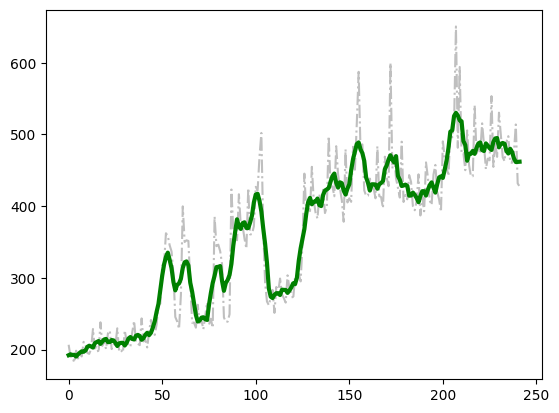

In [48]:
moving_average = sales_avg_week['sales'].rolling(window=7, center=True, min_periods=4).mean()   
ax = sales_avg_week['sales'].plot(color='0.75', linestyle='dashdot')
ax = moving_average.plot(linewidth=3, color='g')

Trends Forecasting

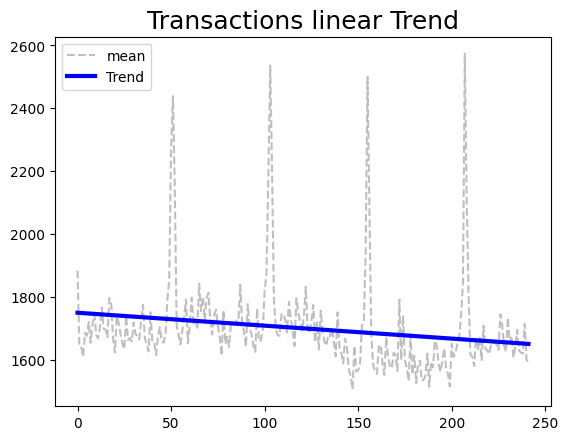

In [49]:
dp_transactions = DeterministicProcess(index=transactions_avg_week.index, constant=True, order=1, drop=True)    
X = dp_transactions.in_sample()
y = transactions_avg_week['transactions']
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.Series(model.predict(X), index=X.index)
ax = y.plot(linestyle='dashed', label="mean", color="0.75")
ax = y_pred.plot(linewidth=3, label="Trend", color='b')
ax.set_title('Transactions linear Trend', fontsize=18)  
_ = ax.legend()

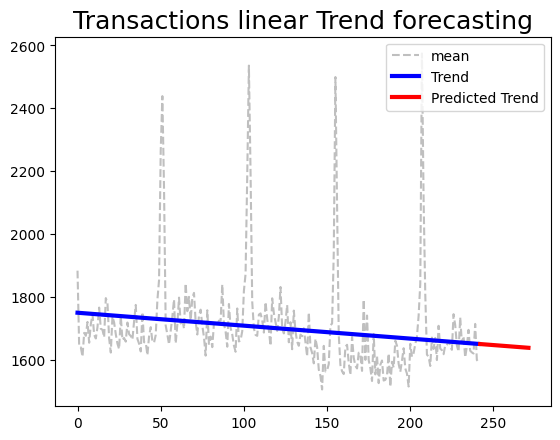

In [50]:
steps = 30 
X = dp_transactions.out_of_sample(steps=steps)
y_fore = pd.Series(model.predict(X), index=X.index)
y_fore.head()
ax = y.plot(linestyle='dashed', label="mean", color="0.75")
ax = y_pred.plot(linewidth=3, label="Trend", color='b')
ax = y_fore.plot(linewidth=3, label="Predicted Trend", color='r')
ax.set_title('Transactions linear Trend forecasting', fontsize=18)  
_ = ax.legend()

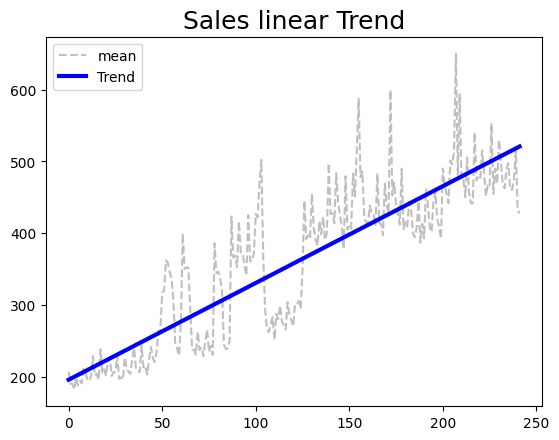

In [51]:
dp_sales = DeterministicProcess(index=sales_avg_week.index, constant=True, order=1, drop=True)    
X = dp_sales.in_sample()
y = sales_avg_week['sales']
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.Series(model.predict(X), index=X.index)
ax = y.plot(linestyle='dashed', label="mean", color="0.75")
ax = y_pred.plot(linewidth=3, label="Trend", color='b')
ax.set_title('Sales linear Trend', fontsize=18)  
_ = ax.legend()

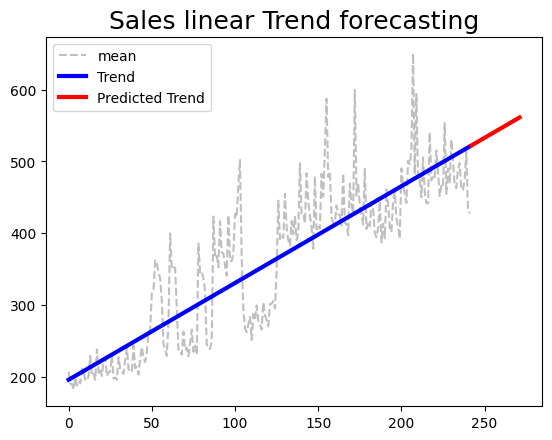

In [52]:
steps = 30 
X = dp_sales.out_of_sample(steps=steps)
y_fore = pd.Series(model.predict(X), index=X.index)
y_fore.head()
ax = y.plot(linestyle='dashed', label="mean", color="0.75")
ax = y_pred.plot(linewidth=3, label="Trend", color='b')
ax = y_fore.plot(linewidth=3, label="Predicted Trend", color='r')
ax.set_title('Sales linear Trend forecasting', fontsize=18)  
_ = ax.legend()

Time series as features

In [53]:
store_sales = train.copy()
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean() 
    .unstack('family')
    .loc['2013', ['sales', 'onpromotion']]
)

meat_sales = family_sales.loc(axis=1)[:, 'MEATS']

In [54]:
store_sales

id  sales  onpromotion  year  month  \
store_nbr family     date                                                   
1         AUTOMOTIVE 2013-01-01        0    0.0            0  2013      1   
                     2013-01-02     1782    2.0            0  2013      1   
                     2013-01-03     3564    3.0            0  2013      1   
                     2013-01-04     5346    3.0            0  2013      1   
                     2013-01-05     7128    5.0            0  2013      1   
...                                  ...    ...          ...   ...    ...   
54        SEAFOOD    2017-08-11  2993627    0.0            0  2017      8   
                     2017-08-12  2995409    1.0            1  2017      8   
                     2017-08-13  2997191    2.0            0  2017      8   
                     2017-08-14  2998973    0.0            0  2017      8   
                     2017-08-15  3000755    3.0            0  2017      8   

                                 day_of_week  week  
store_nbr family     date                           
1         AUTOMOTIVE 2013-01-01            2     1  
                     2013-01-02            3     1  
                     2013-01-03            4     1  
                     2013-01-04            5     1  
                     2013-01-05            6     1  
...                                      ...   ...  
54        SEAFOOD    2017-08-11            5    32  
                     2017-08-12            6    32  
                     2017-08-13            7    32  
                     2017-08-14            1    33  
                     2017-08-15            2    33  

[3000888 rows x 7 columns]

In [55]:
meat_sales

,sales,onpromotion
family,MEATS,MEATS
date,,
2013-01-01,2.051870,0.0
2013-01-02,386.508593,0.0
2013-01-03,307.359224,0.0
2013-01-04,400.480797,0.0
2013-01-05,386.649834,0.0
...,...,...
2013-12-27,378.668519,0.0
2013-12-28,343.903369,0.0


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:568: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)


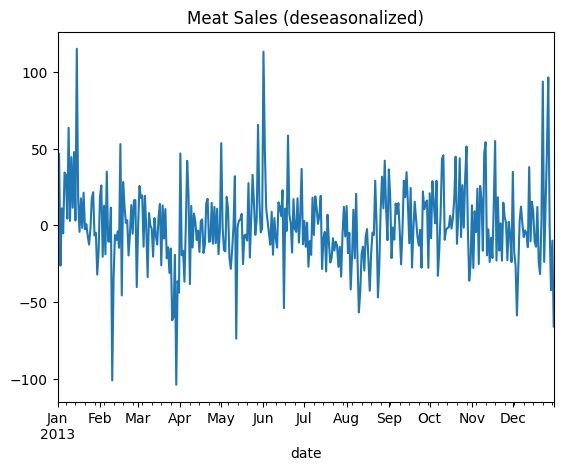

In [56]:
y = meat_sales.loc[:, 'sales'].squeeze()

fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    constant=True,
    index=y.index,
    order=1,
    seasonal=True,
    drop=True,
    additional_terms=[fourier],
)
X_time = dp.in_sample()
X_time['NewYearsDay'] = (X_time.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X_time, y)
y_deseason = y - model.predict(X_time)
y_deseason.name = 'sales_deseasoned'

ax = y_deseason.plot()
ax.set_title("Meat Sales (deseasonalized)");

In [57]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(alpha=0.75,s=3)
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_, y=y_, scatter_kws=scatter_kws, line_kws=line_kws, lowess=True, ax=ax, **kwargs)
    at = AnchoredText(f"{corr:.2f}",prop=dict(size="large"), frameon=True, loc="upper left")
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2 + 10, nrows * 2 + 5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

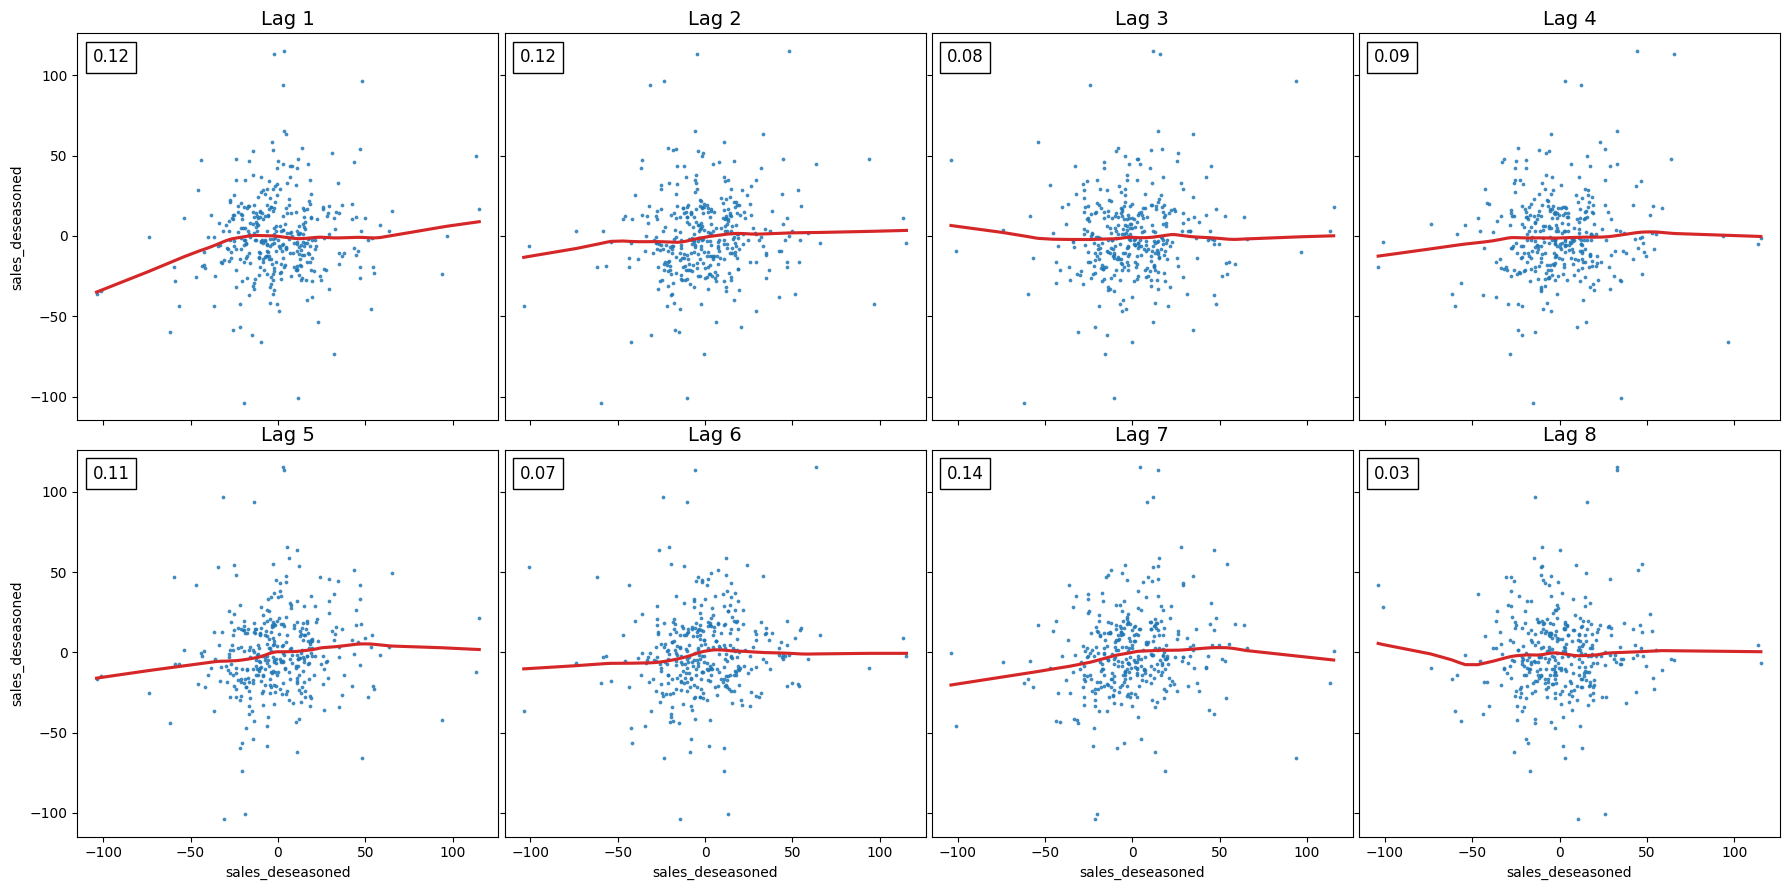

In [58]:
_ = plot_lags(y_deseason, lags=8, nrows=2)

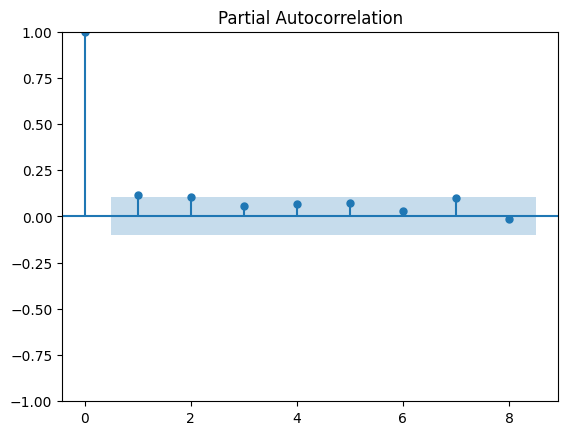

In [59]:
_ = plot_pacf(y_deseason, lags=8)

/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/opt/conda/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


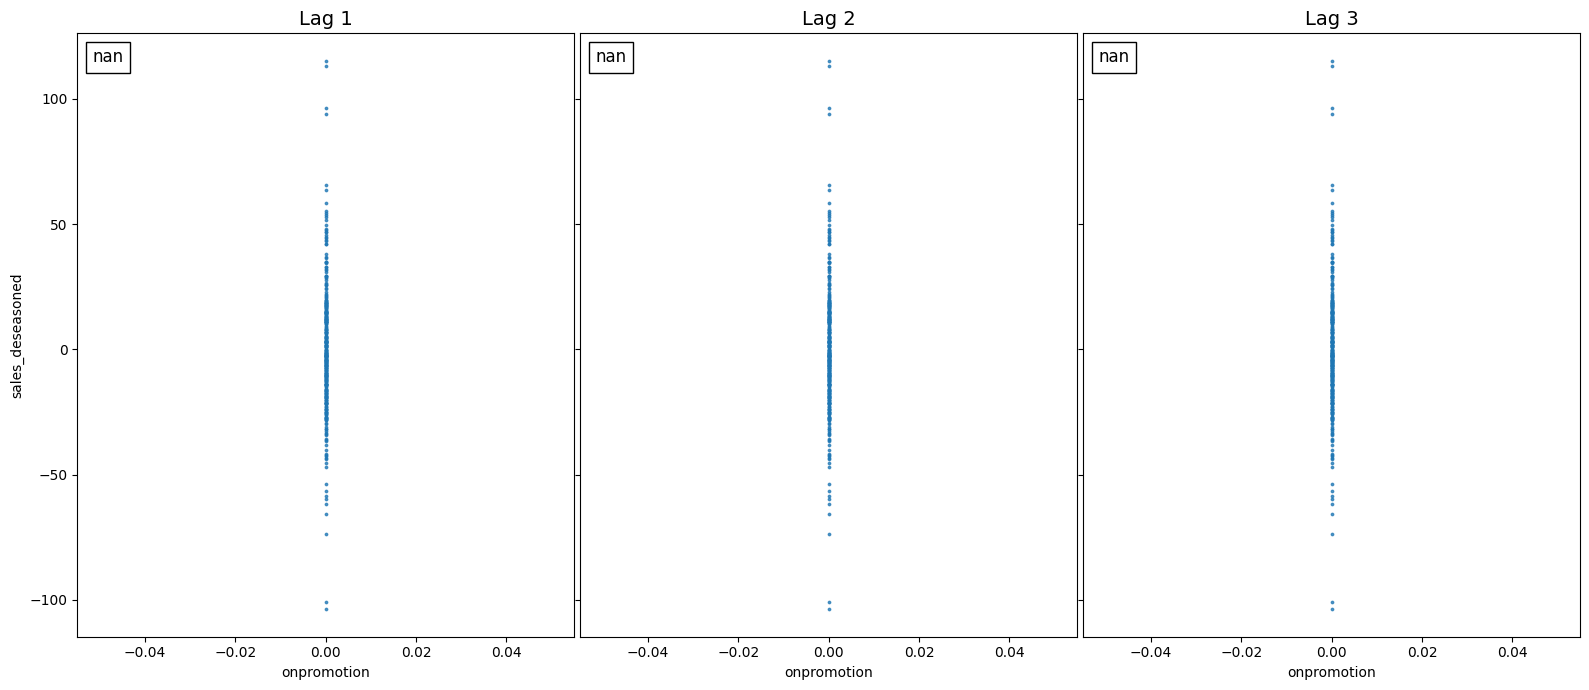

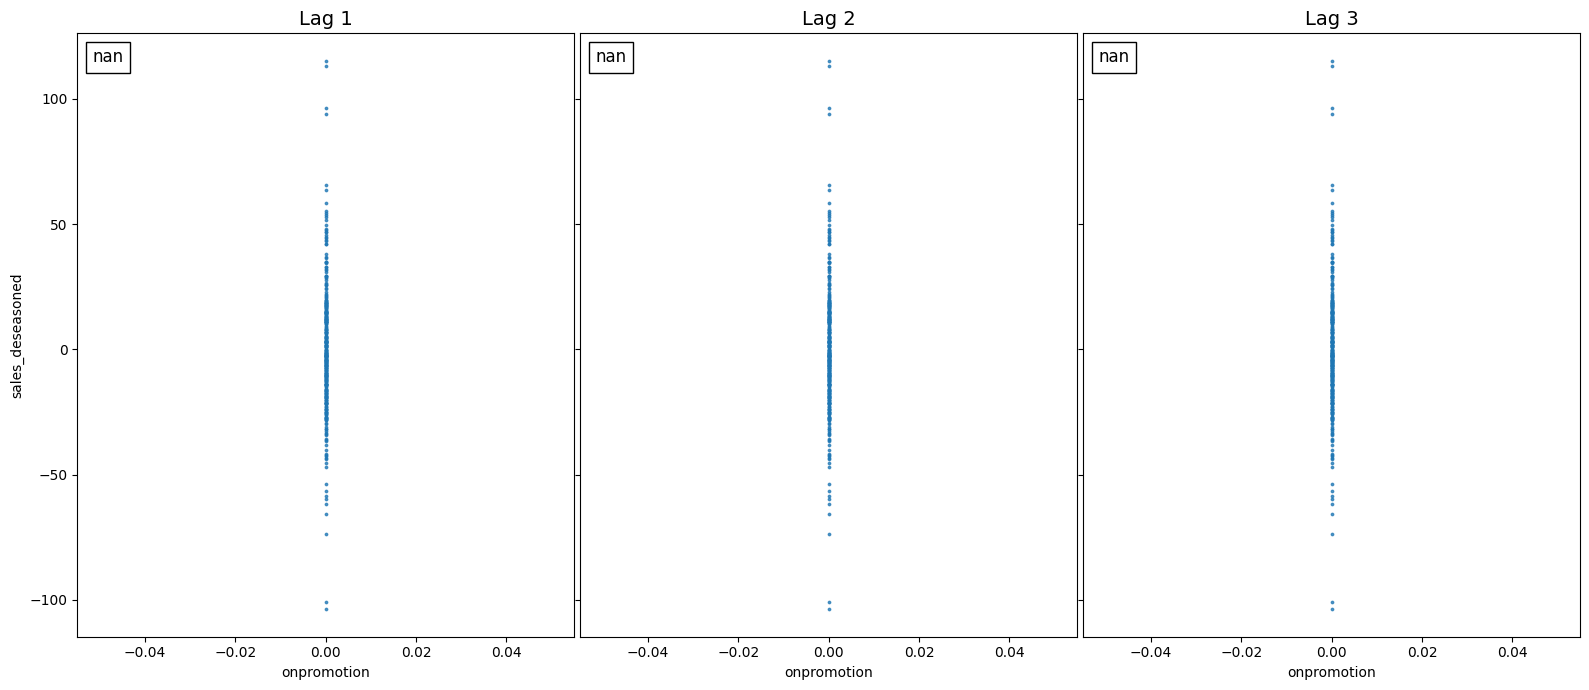

In [60]:
onpromotion = meat_sales.loc[:, 'onpromotion'].squeeze().rename('onpromotion')

# Drop the New Year outlier
plot_lags(x=onpromotion.iloc[1:], y=y_deseason.iloc[1:], lags=3, nrows=1)

Lags forecasting

In [61]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)

In [62]:
X = make_lags(y_deseason, lags=4)
X = X.fillna(0.0)

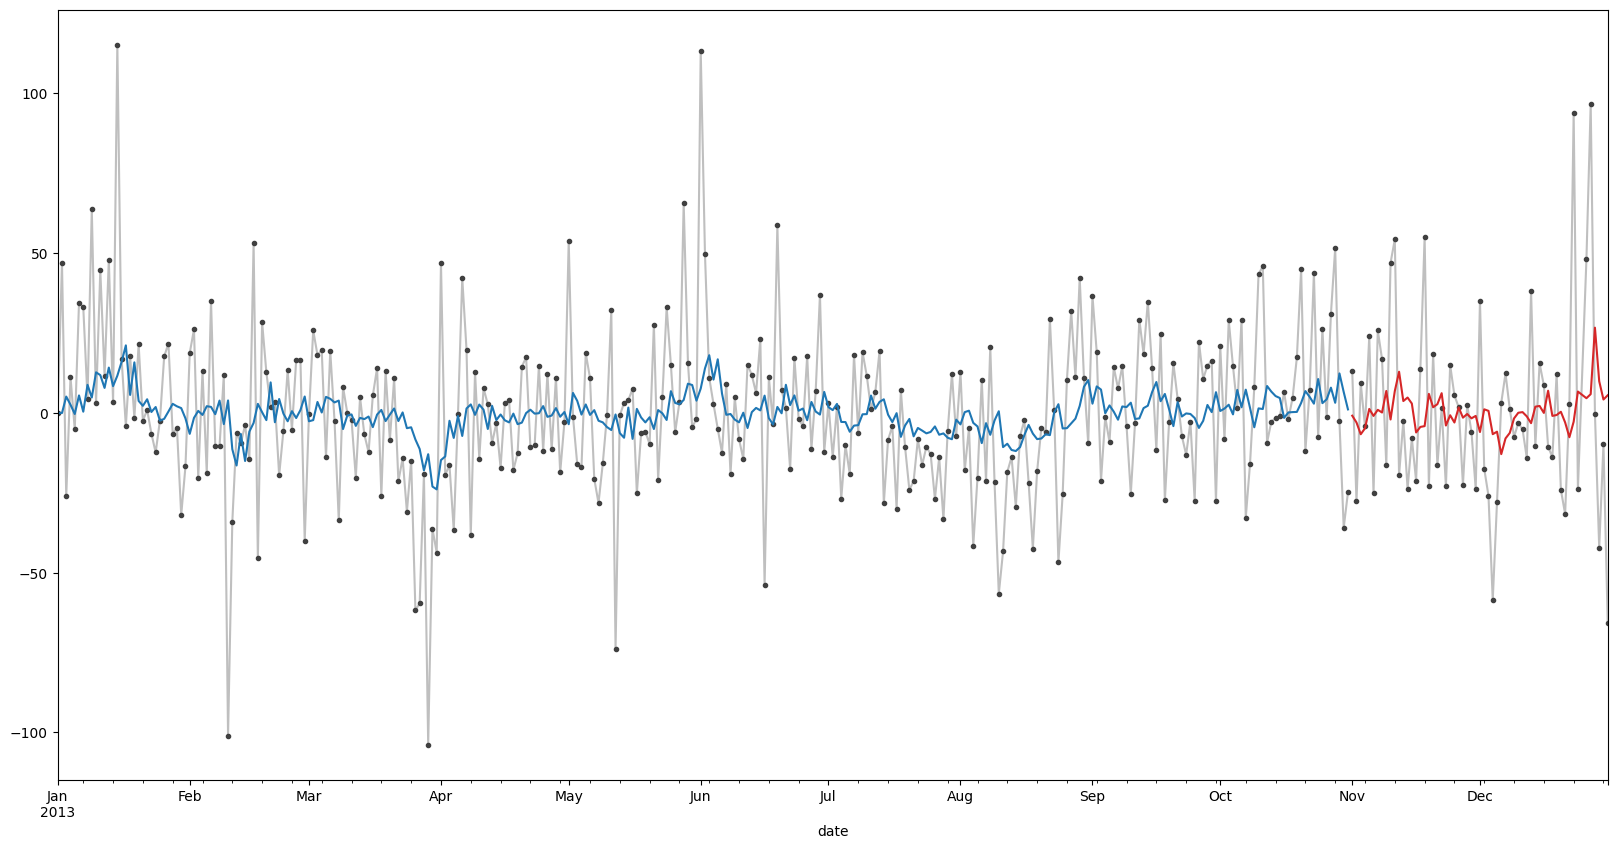

In [63]:
y = y_deseason.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

# Fit and predict
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
ax = y_train.plot(color="0.75", style=".-", markeredgecolor="0.25", markerfacecolor="0.25", ax=ax)
ax = y_test.plot(color="0.75",style=".-",markeredgecolor="0.25", markerfacecolor="0.25", ax=ax)
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')
plt.show()

Hybrid models

In [64]:
family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2013'])

In [65]:
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method

In [66]:
def fit(self, X_1, X_2, y):
    # train model_1
    self.model_1.fit(X_1, y)

    # make predictions
    y_fit = pd.DataFrame(
        self.model_1.predict(X_1), 
        index=X_1.index, columns=y.columns,
    )

    # compute residuals
    y_resid = y - y_fit
    y_resid = y_resid.stack().squeeze() # wide to long

    # train model_2 on residuals
    self.model_2.fit(X_2, y_resid)

    # save column names for predict method
    self.y_columns = y.columns
    # Save data for question checking
    self.y_fit = y_fit
    self.y_resid = y_resid


# Add method to class
BoostedHybrid.fit = fit

In [67]:
def predict(self, X_1, X_2):
    # Predict with model_1
    y_pred = pd.DataFrame(
        self.model_1.predict(X_1), 
        index=X_1.index, columns=self.y_columns,
    )
    y_pred = y_pred.stack().squeeze()  # wide to long

    # Add model_2 predictions to model_1 predictions
    y_pred += self.model_2.predict(X_2)

    return y_pred.unstack()


# Add method to class
BoostedHybrid.predict = predict

In [68]:
# Target series
y = family_sales.loc[:, 'sales']


# X_1: Features for Linear Regression
dp = DeterministicProcess(index=y.index, order=1)
X_1 = dp.in_sample()


# X_2: Features for XGBoost
X_2 = family_sales.drop('sales', axis=1).stack()  # onpromotion feature

# Label encoding for 'family'
le = LabelEncoder()  # from sklearn.preprocessing
X_2 = X_2.reset_index('family')
X_2['family'] = le.fit_transform(X_2['family'])

# Label encoding for seasonality
X_2["day"] = X_2.index.day  # values are day of the month

/tmp/ipykernel_18/3489191612.py:11: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  X_2 = family_sales.drop('sales', axis=1).stack()  # onpromotion feature


In [69]:
# Create model
model = BoostedHybrid(
    model_1=LinearRegression(),
    model_2=XGBRegressor())

model.fit(X_1, X_2, y)

y_pred = model.predict(X_1, X_2)
y_pred = y_pred.clip(0.0)

In [70]:
# Boosted Hybrid
model = BoostedHybrid(
    model_1=Lasso(),
    model_2=KNeighborsRegressor(),
)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_18/4142320562.py:21: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  _ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
/tmp/ipykernel_18/4142320562.py:22: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  _ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)


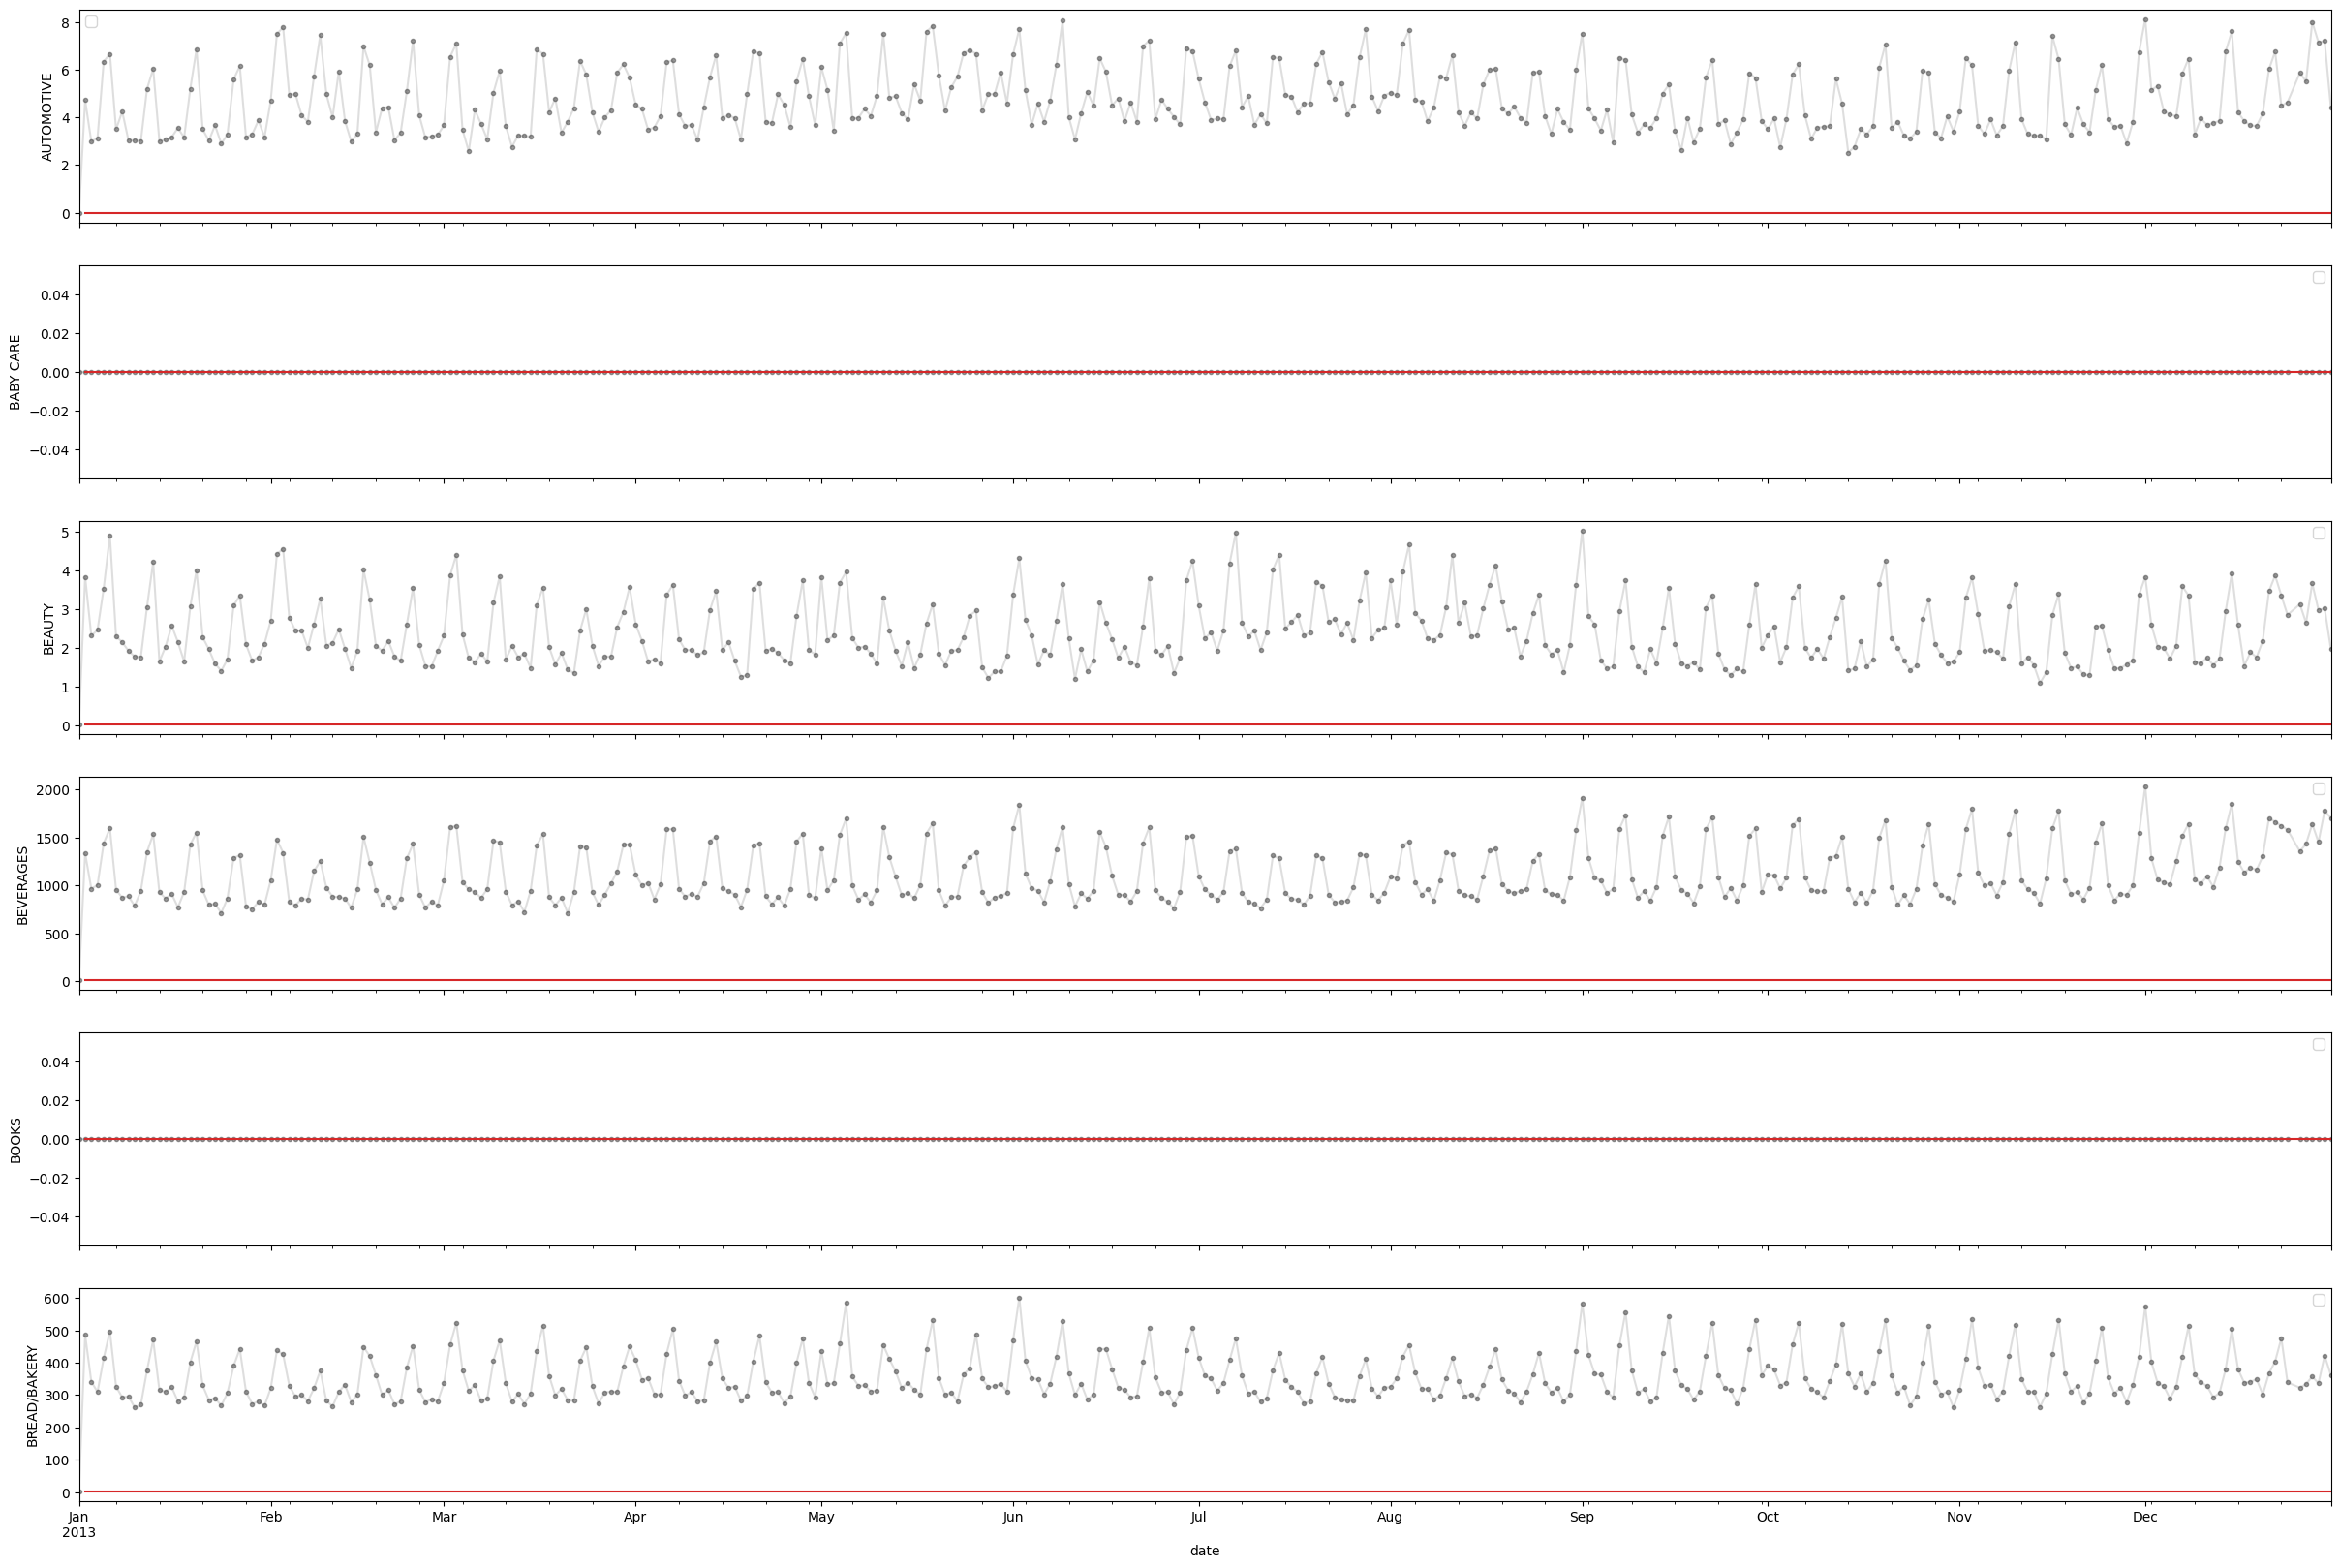

In [71]:
y_train, y_valid = y[:"2013-01-01"], y["2013-01-02":]
X1_train, X1_valid = X_1[: "2013-01-01"], X_1["2013-01-02" :]
X2_train, X2_valid = X_2.loc[:"2013-01-01"], X_2.loc["2013-01-02":]

# Some of the algorithms above do best with certain kinds of
# preprocessing on the features (like standardization), but this is
# just a demo.
model.fit(X1_train, X2_train, y_train)
y_fit = model.predict(X1_train, X2_train).clip(0.0)
y_pred = model.predict(X1_valid, X2_valid).clip(0.0)

families = y.columns[0:6]
axs = y.loc(axis=1)[families].plot(subplots=True, 
                                   sharex=True, 
                                   figsize=(30, 20), 
                                   color="0.75",
                                   style=".-",
                                   markeredgecolor="0.25",
                                   markerfacecolor="0.25",
                                   alpha=0.5)
_ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
_ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)
for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)

Machine learning forecasting

In [72]:
test['date'] = test['date'].dt.to_period('D')
test = test.set_index(['store_nbr', 'family', 'date']).sort_index()

In [73]:
def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)

In [74]:
y = family_sales.loc[:, 'sales']

# make 4 lag features
X = make_lags(y, lags=5).dropna()

# make multistep target
y = make_multistep_target(y, steps=16).dropna()

y, X = y.align(X, join='inner', axis=0)

In [75]:
le = LabelEncoder()
X = (X
    .stack('family')  # wide to long
    .reset_index('family')  # convert index to column
    .assign(family=lambda x: le.fit_transform(x.family))  # label encode
)
y = y.stack('family')  # wide to long

display(y) 

/tmp/ipykernel_18/2956288862.py:3: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack('family')  # wide to long
/tmp/ipykernel_18/2956288862.py:7: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y = y.stack('family')  # wide to long


y_step_1    y_step_2    y_step_3  \
date       family                                                            
2013-01-06 AUTOMOTIVE                     6.666667    3.500000    4.240741   
           BABY CARE                      0.000000    0.000000    0.000000   
           BEAUTY                         4.907407    2.296296    2.148148   
           BEVERAGES                   1596.000000  955.907407  869.277778   
           BOOKS                          0.000000    0.000000    0.000000   
...                                            ...         ...         ...   
2013-12-15 POULTRY                      498.336371  385.335905  354.596759   
           PREPARED FOODS               119.586500   90.120074   83.661333   
           PRODUCE                        6.277778    2.629630    2.055556   
           SCHOOL AND OFFICE SUPPLIES     0.000000    0.000000    0.000000   
           SEAFOOD                       21.194667   15.427833   18.186167   

                                         y_step_4    y_step_5    y_step_6  \
date       family                                                           
2013-01-06 AUTOMOTIVE                    3.037037    3.037037    3.000000   
           BABY CARE                     0.000000    0.000000    0.000000   
           BEAUTY                        1.925926    1.777778    1.759259   
           BEVERAGES                   887.222222  785.000000  940.611111   
           BOOKS                         0.000000    0.000000    0.000000   
...                                           ...         ...         ...   
2013-12-15 POULTRY                     393.795571  407.767574  472.973669   
           PREPARED FOODS               86.970111   88.004204   88.294167   
           PRODUCE                       3.518519    4.407407    8.462963   
           SCHOOL AND OFFICE SUPPLIES    0.000000    0.000000    0.000000   
           SEAFOOD                      18.597667   15.505352   17.309333   

                                          y_step_7     y_step_8    y_step_9  \
date       family                                                             
2013-01-06 AUTOMOTIVE                     5.185185     6.037037    3.000000   
           BABY CARE                      0.000000     0.000000    0.000000   
           BEAUTY                         3.055556     4.222222    1.648148   
           BEVERAGES                   1347.296296  1534.333333  929.537037   
           BOOKS                          0.000000     0.000000    0.000000   
...                                            ...          ...         ...   
2013-12-15 POULTRY                      531.847666   541.881333  578.745464   
           PREPARED FOODS               107.916611   112.189203  103.888963   
           PRODUCE                       10.148148     7.259259    5.666667   
           SCHOOL AND OFFICE SUPPLIES     0.000000     0.000000    0.000000   
           SEAFOOD                       18.239759    18.664741   16.500518   

                                        y_step_10   y_step_11   y_step_12  \
date       family                                                           
2013-01-06 AUTOMOTIVE                    3.055556    3.166667    3.555556   
           BABY CARE                     0.000000    0.000000    0.000000   
           BEAUTY                        2.037037    2.574074    2.148148   
           BEVERAGES                   863.037037  909.666667  771.222222   
           BOOKS                         0.000000    0.000000    0.000000   
...                                           ...         ...         ...   
2013-12-15 POULTRY                     545.097075  312.800315  375.342870   
           PREPARED FOODS               91.492555   81.548056   89.613963   
           PRODUCE                       7.592593    5.351852    8.333333   
           SCHOOL AND OFFICE SUPPLIES    0.000000    0.000000    0.000000   
           SEAFOOD                      12.776833   17.909000   20.660222

In [76]:
model = RegressorChain(base_estimator=XGBRegressor())

In [77]:
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=y.index,columns=y.columns).clip(0.0)

In [78]:
def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

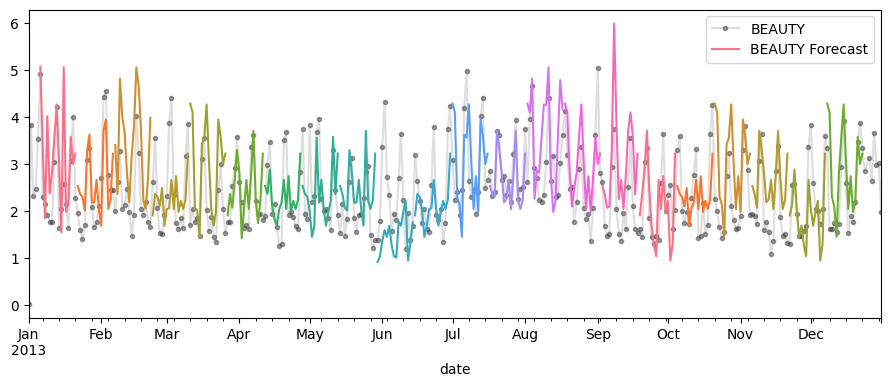

In [79]:
FAMILY = 'BEAUTY'
START = '2013-01-01'
EVERY = 16

y_pred_ = y_pred.xs(FAMILY, level='family', axis=0).loc[START:]
y_ = family_sales.loc[START:, 'sales'].loc[:, FAMILY]

fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax = y_.plot(color="0.75",style=".-",markeredgecolor="0.25", markerfacecolor="0.25",ax=ax, alpha=0.5)
ax = plot_multistep(y_pred_,ax=ax, every=EVERY)
_ = ax.legend([FAMILY, FAMILY + ' Forecast'])